# **Bio 378 Group Project**

### By Luke Malaisrie, Julia Nelson, Emma Oswalt, & Meng Tao

### Group 8: Familial Cardiomyopathy

# **Basic Information**

Link to Dataset: https://www.ebi.ac.uk/gxa/experiments/E-GEOD-112057/Results

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

from google.colab import drive
drive.mount('./bio_378_data')

query_results = pd.read_csv('/content/bio_378_data/MyDrive/colab_notebooks/E-GEOD-112057-analytics.tsv', sep ='\t')
analytics = pd.read_csv('/content/bio_378_data/MyDrive/colab_notebooks/E-GEOD-112057-analytics.tsv', sep = '\t')
raw_counts = pd.read_csv('/content/bio_378_data/MyDrive/colab_notebooks/E-GEOD-112057-raw-counts.tsv', sep ='\t')
exp_design = pd.read_csv('/content/bio_378_data/MyDrive/colab_notebooks/E-GEOD-112057-experiment-design.tsv', sep ='\t')

Drive already mounted at ./bio_378_data; to attempt to forcibly remount, call drive.mount("./bio_378_data", force_remount=True).


For this project, we will explore a data set that examines genetic and immunological differences between healthy juveniles, juvenile patients with different types of inflammatory bowel disease (IBD), and juvenile patients with different types of juvenile idiopathic arthritis (JIA). Inflammatory bowel diseases are diseases that cause inflammation in the gastrointestinal tract, primarily in the small intestine and/or colon. Around 80,000 children in the United States suffer from an inflammatory bowel disease today. There are two main types of inflammatory bowel disease: Crohn’s disease and ulcerative colitis. On the other hand, juvenile idiopathic arthritis is an autoimmune disease in children that results in inflammation of the joints. Juvenile idiopathic arthritis is the most common type of arthritis among children. The three main types of juvenile idiopathic arthritis are oligoarticular, polyarticular, and systemic. In their study, researchers collected whole-blood samples from 202 juvenile patients and performed RNA-seq from the following groups:

•	12 healthy individuals (control group)

•	60 patients with Crohn’s Disease (IBD type I)

•	15 patients with ulcerative colitis (IBD type II)

•	43 patients with oligoarticular juvenile idiopathic arthritis (JIA type I)

•	46 patients with polyarticular juvenile idiopathic arthritis (JIA type II)

•	26 patients with systemic juvenile idiopathic arthritis (JIA type III)

The data was originally published by Mo et. al. (2018). We imported this data set in the cell above.



# **Normalization**

In [ ]:
#Functions allow for normalization of data

def get_tmm(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)

    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]]
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = counts_slim[test_col].sum()
    n_r = counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    w_k = (n_k - counts_slim[test_col].values)/(n_k*counts_slim[test_col].values) + (n_r - counts_slim[ref_col].values)/(n_r*counts_slim[ref_col].values)

    trim_array_m = (m_k <= np.percentile(m_k, 100*(1-(trim_m/2)))) & ((m_k >= np.percentile(m_k, 100*((trim_m/2)))))
    trim_array_a = (a_k <= np.percentile(a_k, 100*(1-(trim_a/2)))) & ((a_k >= np.percentile(a_k, 100*((trim_a/2)))))

    m_k = m_k[trim_array_m & trim_array_a]
    a_k = a_k[trim_array_m & trim_array_a]
    w_k = w_k[trim_array_m & trim_array_a]
    tmm_k = 2**(np.sum(w_k*m_k)/np.sum(w_k))
    return tmm_k

def get_m_a(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):

    '''
        Calculates TMM value between ref_col and test_col

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        test_col = test columns (str)
        trim_m = extremes to trim when taking trimmed mean of M values (float)
        trim_a = extremes to trim when taking trimmed mean of M values (float)

    '''

    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]].copy()
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = 1 #counts_slim[test_col].sum()
    n_r = 1 #counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    return m_k, a_k

def norm_tmm(counts, columns_to_norm, ref_col=None):
    '''
        Normalizes count matrix by TMM.

        counts = count matrix (pd.DataFrame)
        ref_col = reference column (str)
        columns_to_norm = columns to be normed (str)

    '''
    if ref_col == None:
        ref_col = columns_to_norm[0]
    counts[counts.columns[~counts.columns.isin(columns_to_norm)]]

    tmm_array = []
    for col in columns_to_norm:
        tmm_array.append(get_tmm(counts = counts, ref_col=ref_col, test_col=col))
    tmm_array = np.array(tmm_array)
    #print(tmm_array)

    norm_counts = counts[columns_to_norm]/(np.sqrt(tmm_array)*counts[columns_to_norm].sum(axis=0))
    norm_counts[counts.columns[~counts.columns.isin(columns_to_norm)]] = counts[counts.columns[~counts.columns.isin(columns_to_norm)]]
    return norm_counts

In [ ]:
# Normalization

exp_design = exp_design[exp_design['Analysed'] == 'Yes'].reset_index(drop=True)

exp_design['labels'] = ['']*len(exp_design)

# re-labeling
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["Crohn disease"]).all(axis=1), 'labels'] = 'Crohn'
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["ulcerative colitis (disease)"]).all(axis=1), 'labels'] = 'UC'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "systemic-onset juvenile idiopathic arthritis"), 'labels'] = 'SJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "polyarticular juvenile idiopathic arthritis"), 'labels'] = 'PJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "oligoarticular juvenile idiopathic arthritis"), 'labels'] = 'OJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "normal"), 'labels'] = 'NORM'

exp_design = exp_design.sort_values('labels')
cols_to_norm = exp_design['Run'].values
labels = exp_design['labels'].values

# normalizing
counts_norm = raw_counts.copy()
counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

# data normalization
# compare bowel diseases to normal
# compare arthritises to normal
query_results.columns = ['Gene ID', 'Gene Name',
 'Crohn_vs_NORM_p', 'Crohn_vs_NORM_fc',
 'OJIA_vs_NORM_p', 'OJIA_vs_NORM_fc',
 'PJIA_vs_NORM_p', 'PJIA_vs_NORM_fc',
 'SJIA_vs_NORM_p', 'SJIA_vs_NORM_fc',
 'UC_vs_NORM_p', 'UC_vs_NORM_fc',]


In [ ]:
### Data clean up

# filter for analysed sample in data
exp_design = exp_design[exp_design['Analysed'] == 'Yes'].reset_index(drop=True)

# make an new column called label to store abbreviation
exp_design['labels'] = ['']*len(exp_design)

# re-labeling by abbreviation
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["Crohn disease"]).all(axis=1), 'labels'] = 'Crohn'
exp_design.loc[(exp_design[['Factor Value[disease]']].values == ["ulcerative colitis (disease)"]).all(axis=1), 'labels'] = 'UC'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "systemic-onset juvenile idiopathic arthritis"), 'labels'] = 'SJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "polyarticular juvenile idiopathic arthritis"), 'labels'] = 'PJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "oligoarticular juvenile idiopathic arthritis"), 'labels'] = 'OJIA'
exp_design.loc[(exp_design['Factor Value[disease]'].values == "normal"), 'labels'] = 'NORM'

# sort exp design by condition
exp_design = exp_design.sort_values('labels')

#filter only Run tag for further normalization
cols_to_norm = exp_design['Run'].values

#preserve label for future use
labels = exp_design['labels'].values

# make copy for query and counts to save raw data
query_result = query_results.copy()
counts_norm = raw_counts.copy()

# re-naming query results columns based on relabeled abbreviation
query_result.columns = ['Gene ID', 'Gene Name',
 'Crohn_vs_NORM_fc', 'Crohn_vs_NORM_p',
 'OJIA_vs_PJIA_fc', 'OJIA_vs_PJIA_p',
 'PJIA_vs_SJIA_fc', 'PJIA_vs_SJIA_p',
 'SJIA_vs_NORM_fc', 'SJIA_vs_NORM_p',
 'UC_vs_NORM_fc', 'UC_vs_NORM_p',]

We are performing trimmed mean of m-values (TMM) normalization on raw counts for further data analysis based on the method parts ( in paper they also conduct normalization to remove batch effects by surrogate variable analysis (SVA) combined with supervised normalization).
TMM is a commonly used normalization method in high-throughput genomic analysis adjust for both library size and relative abundence of different genes. TMM normalization assume that the majority of genes, c
ommon to the samples, are not differentially expressed. A trimmed mean is the average after removing the upper and lower x% of the data. The M-value is the log2 ratio of the counts between two samples, and the A-value is the average log2 counts of the two samples (in this case we are using the first sample as reference sample and the rest as test scample). If the null hypothese of no genes expressed differently is true the mean should be 1, and other differential expression is diverge from 1.


In [ ]:
### normalizing using trimmed mean of m-values (TMM) normalization

# make a copy of raw counts
counts_norm = raw_counts.copy()
# filter only Run tag for normalization
cols_to_norm = exp_design['Run'].values
# perform TMM using the first column as reference column
counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])
# print out the results of normalization
counts_norm

,SRR6868540,SRR6868542,SRR6868687,SRR6868650,SRR6868639,SRR6868637,SRR6868636,SRR6868623,SRR6868622,SRR6868621,...,SRR6868543,SRR6868665,SRR6868685,SRR6868653,SRR6868558,SRR6868686,SRR6868620,SRR6868579,Gene ID,Gene Name
0,8.273689e-08,4.106711e-07,4.944110e-07,6.348618e-07,1.796381e-07,1.021642e-07,3.562783e-07,1.665813e-07,2.169778e-07,7.622796e-07,...,4.960244e-07,7.603543e-08,4.021989e-07,6.222915e-07,3.930862e-07,7.816162e-08,8.985604e-08,1.267797e-07,ENSG00000000003,TSPAN6
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,ENSG00000000005,TNMD
2,2.672402e-05,2.997899e-05,2.313844e-05,2.209319e-05,2.308350e-05,2.513239e-05,2.339561e-05,2.432087e-05,3.504192e-05,2.689758e-05,...,2.599168e-05,2.410323e-05,2.865667e-05,2.821055e-05,2.410928e-05,1.954041e-05,3.144962e-05,2.877899e-05,ENSG00000000419,DPM1
3,1.530632e-05,1.560550e-05,1.305245e-05,1.472879e-05,1.904164e-05,2.308910e-05,1.591376e-05,1.499232e-05,2.017894e-05,1.535449e-05,...,1.587278e-05,1.771626e-05,1.518301e-05,1.908361e-05,1.048230e-05,1.485071e-05,1.311898e-05,1.762238e-05,ENSG00000000457,SCYL3
4,2.647580e-06,3.559149e-06,1.977644e-06,2.412475e-06,3.502943e-06,1.225970e-06,2.968986e-06,2.665301e-06,3.146179e-06,1.851250e-06,...,3.472171e-06,3.573665e-06,3.117041e-06,3.837465e-06,1.965431e-06,3.595435e-06,2.066689e-06,2.915933e-06,ENSG00000000460,C1orf112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58730,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,ENSG00000285990,NBEAP6
58731,0.000000e+00,0.000000e+00,0.000000e+00,1.269724e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.665813e-07,0.000000e+00,0.000000e+00,...,0.000000e+00,7.603543e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.563232e-07,8.985604e-08,0.000000e+00,ENSG00000285991,NaN
58732,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,ENSG00000285992,NaN
58733,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,ENSG00000285993,NaN


In [ ]:

a = counts_norm[cols_to_norm].values[:,labels == 'Crohn']
b = counts_norm[cols_to_norm].values[:,labels == 'UC']
c = counts_norm[cols_to_norm].values[:,labels == 'SJIA']
d = counts_norm[cols_to_norm].values[:,labels == 'PJIA']
e = counts_norm[cols_to_norm].values[:,labels == 'OJIA']
f = counts_norm[cols_to_norm].values[:,labels == 'NORM']

counts_norm['anova_p'] = scipy.stats.f_oneway(a.T, b.T, c.T, d.T, e.T, f.T).pvalue
counts_norm = counts_norm.dropna(subset=['anova_p'])
counts_norm['bonferroni_fwer'] = counts_norm['anova_p']*len(counts_norm['anova_p'])
counts_norm.loc[counts_norm['bonferroni_fwer'] > 1, 'bonferroni_fwer'] = 1.0
counts_norm['bh_fdr'] = counts_norm['anova_p']*len(counts_norm['anova_p'])/counts_norm['anova_p'].rank()
counts_norm.loc[counts_norm['bh_fdr'] > 1, 'bh_fdr'] = 1.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
<ipython-input-102-897bbd9a6897>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_norm['bonferroni_fwer'] = counts_norm['anova_p']*len(counts_norm['anova_p'])
<ipython-input-102-897bbd9a6897>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_norm['bh_fdr'] = counts_norm['ano

# **Hierarchical Clustering**

We first perform the heriarchical clustering on TMM normalized data. We selected 9335 genes that its Bonferroni-adjusted p-values < 0.05.

In [ ]:
###Perform preliminary clutersing

# filter with Bonferroni-adjusted p-values < 0.05
counts_norm_slim = counts_norm[counts_norm['bh_fdr'] < 0.05]
counts_norm_slim = counts_norm_slim.set_index('Gene Name')[cols_to_norm]
counts_norm_slim.columns = labels

# Define colors to label our columns to make the diagnosis categories of our clustermap easier to read
lut = dict(zip(np.unique(labels), ['b', 'k', 'g', 'r', 'y', 'm']))  # Color code
col_colors = pd.DataFrame(labels)[0].map(lut)

g = sns.clustermap(counts_norm_slim, # data to cluster
                   method='ward', # method for heiarchical clustering
                   col_cluster=True, # cluster columns
                   z_score=0, # axis to perform z standardization
                   vmin=-2.5, vmax=2.5, # upper and lower limits of our colorbar
                   cmap='seismic_r', # palette to use for our colorbar
                   col_colors=[col_colors]) # what colors to label our columns on the margin

ax = g.ax_heatmap
handles1 = [mpl.patches.Patch(facecolor=lut[name]) for name in lut]

leg1 = g.ax_row_dendrogram.legend(handles1, lut, title='diagnosis',
           bbox_to_anchor=(0.97, 0.70), bbox_transform=plt.gcf().transFigure, loc='upper left', frameon=False, fontsize=16)
plt.setp(leg1.get_title(),fontsize=16)
leg1._legend_box.align = "left"

g.ax_cbar.set_title(label='Z-score', fontsize=16)
#plt.savefig('EAC_clustermap.png', dpi=200, bbox_inches='tight')


NameError: name 'counts_norm' is not defined

The heriarchical clustering involved blood samples from five related autoimmue disease and normal control (JIA and IBD characterized by divergent peripheral blood transcriptomes).

Looking at the horizontal dendragram grouped by sample simularity, the genetic regulation of which displays limited disease specificity. By the legend, we can slightly identified the two major cluster with or without Crohn's disease. Interstingly, the other inflammatory bowel disease ulcerative colitis is more scattered in clustering. Simular situation to thrre subtype of JIA discussed. In paper, they further coduct blood cell type clustering which gives a clear pattern of sample relation.

Vertial dendragram on left shows the genetic pattern samilarity. For the two Crohn's disease pattern in, it show some genes more depleted in Crohn's disease group and enhensed in non-Crohn's disease group (cluster0). Rest clusters more show a reversed genetic expression pattern (cluster 2, 3, 4).  

In [ ]:
# generate file for WebGestalt analysis file of four major cluster
df_sliced_scaled = g.data2d
Z = scipy.cluster.hierarchy.ward(df_sliced_scaled)

tree_cut = np.ndarray.flatten(scipy.cluster.hierarchy.cut_tree(Z, n_clusters=4))
tree_cut
df_sliced_scaled

for cluster_id in set(tree_cut):
    pd.DataFrame(df_sliced_scaled[tree_cut == cluster_id].index.values).to_csv('Disease' +
                                                                               str(cluster_id) +
                                                                               '_gene_symbol.txt',
                                                                               header=False,
                                                                               index=False)

pd.DataFrame(counts_norm['Gene Name'].values).to_csv('Disease_cluster_reference_gene_symbol.txt', header=False, index=False)

Cluster0: hsa04380 Osteoclast differentiation https://www.webgestalt.org/results/1710088262/#

Cluster1: hsa05332 Graft-versus-host disease https://www.webgestalt.org/results/1710088304/#

Cluster2: hsa03008 Ribosome biogenesis in eukaryotes https://www.webgestalt.org/results/1710088318/#

Cluster3: hsa01100 Metabolic pathways https://www.webgestalt.org/results/1710088326/#


By doing tree-cut and run WebGestalt analysis on the four cluster of genes and identified some gene characterics (KEGG).

**Cluster 0** which mostly enriched in three subtype of juvenile idiopathic arthritis but depleted in Crohn's dominate groups is osteoclast differentiation. Osteoclasts are cells of monocyte/macrophage origin that degrade bone matrix, which helps development and maintenance of the skeletal system, as well as for the pathological destruction of bone in diseases such as arthritis. Since the most vesiable sample group is with or with-less Crohn's disease (horizontial dendragram cluster 0 and cluster1), it is reasonable that one differenical clustering of gene involved in is osteal genes.  

**Cluster 1** genes related to graft-versus-host disease is a sets of post transplant disease which involved in immunenity. **Cluster 2 and 3** are more general metabolic genes and cellular functionality aspects with some house-keeping genes.

Further devied in cluster 2 and 3 will help find more useful details on disease specific difference or simularity in these five autoimmune disease. In addition, since the samples are generates from blood transcriptomes, it may also biase the disease specificity and it can be improved by more specific tissue sample RNA-Seq analysis.

# **Over-Representation Analysis**

In [ ]:
# genes in inflammatory bowel disease KEGG pathway
ibd_pathway = ['NOD2', 'ATG16L1', 'ABCB1', 'IRF5', 'IL23R', 'IRGM', 'IL10RB', 'IL10RA', 'INAVA', 'CARD8', 'IL37', 'IL10', 'MST1']

The inflammatory bowel disease (IBD) KEGG pathway, H01227, has 13 genes. We selected this pathway because Crohn's disease and ulcerative colitis are the two main IBDs, and we would expect these genes to be either significantly upregulated or significantly downregulated in Crohn's and UC as a result. We want to see if our dataset matches other research on the genes involved in Crohn's disease and UC.

First, we will make a volcano plot showing fold-change vs negative log q-value for every gene when we compare Crohn's disease patients to normal patients.

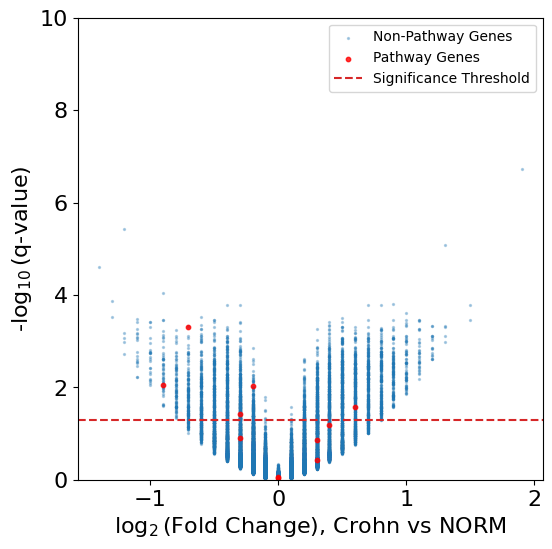

In [ ]:
#volcano plot for Crohn's disease vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["Crohn_vs_NORM_fc"],
            -np.log10(query_results["Crohn_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ibd_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "Crohn_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "Crohn_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), Crohn vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot above shows us qualitatively if genes in our pathway of interest are upregulated or downregulated. Note that anything above the red dotted line is significant. Genes in our pathway are highlighted in red while all other genes are in blue. From the graph we can see that only 1 gene in our pathway of interest is upregulated in Crohn's patients compared to normal patients. We can also see that around 4 genes in our pathway of interest are downregulated in Crohn's patients compared to normal individuals. Let's quantitativly analyze the data to see whether our pathway of interest is significantly enriched in Crohn's patients and determine whether our qualitative observations match our quantitative results.

In [ ]:
query_results

,Gene ID,Gene Name,Crohn_vs_NORM_p,Crohn_vs_NORM_fc,OJIA_vs_NORM_p,OJIA_vs_NORM_fc,PJIA_vs_NORM_p,PJIA_vs_NORM_fc,SJIA_vs_NORM_p,SJIA_vs_NORM_fc,UC_vs_NORM_p,UC_vs_NORM_fc
0,ENSG00000000003,TSPAN6,0.890103,0.0,0.534740,0.2,0.845117,0.1,0.806232,0.1,0.244119,-0.4
1,ENSG00000000005,TNMD,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,ENSG00000000419,DPM1,0.018463,0.3,0.706221,0.1,0.161888,0.2,0.144117,0.2,0.003457,0.4
3,ENSG00000000457,SCYL3,0.807842,0.0,0.648021,0.0,0.550638,0.1,0.442648,0.1,0.692188,0.0
4,ENSG00000000460,C1orf112,0.593875,-0.1,0.598761,0.1,0.541233,0.1,0.662733,0.1,0.915486,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
58730,ENSG00000285990,NBEAP6,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
58731,ENSG00000285991,NaN,NaN,0.3,NaN,0.1,NaN,0.4,NaN,0.3,NaN,0.5
58732,ENSG00000285992,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
58733,ENSG00000285993,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [ ]:
# select genes upregulated in Crohn's vs normal
fc_truth = query_results["Crohn_vs_NORM_fc"] > 0
# significance threshold of 0.05
q_val_truth = query_results["Crohn_vs_NORM_p"] < 0.05

# collect genes upregulated in Crohn's vs normal
crohn_slice = query_results[fc_truth & q_val_truth]
crohn_slice.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_p,Crohn_vs_NORM_fc
2,ENSG00000000419,DPM1,0.018463,0.3
29,ENSG00000002834,LASP1,0.020804,0.4
30,ENSG00000002919,SNX11,0.010853,0.4
39,ENSG00000003402,CFLAR,0.016424,0.5
61,ENSG00000004809,SLC22A16,0.048388,0.6
...,...,...,...,...
58080,ENSG00000284882,NaN,0.038017,0.6
58118,ENSG00000285006,NaN,0.014551,0.9
58251,ENSG00000285444,NaN,0.001429,1.2
58656,ENSG00000285909,NaN,0.024139,0.9


2274 of the 58735 genes in the dataset are significantly upregulated in Crohn's disease.

In [ ]:
# determine which genes in both crohn_slice & ibd_pathway
crohn_cond = crohn_slice['Gene Name'].isin(ibd_pathway)
crohn_filter = crohn_slice[crohn_cond]
crohn_filter.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_p,Crohn_vs_NORM_fc
12047,ENSG00000167207,NOD2,0.02638,0.6


Only one gene, NOD2, is both in the IBD pathway and is significantly upregulated in Crohn's disease.

In [ ]:
# number of genes in crohn_cond
k = np.sum(crohn_cond)
# number of genes in crohn_slice
N = len(crohn_slice)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in analytics
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 1
N = 2274
n = 13
M = 58735
Enrichment ratio: 1.9868412150734052
p-value: 0.40152298798858393


The p-value of .40 (> .05) shows that the inflammatory bowel disease pathway is not significantly enriched in those with Crohn's disease. This is unexpected, as Crohn's disease is an inflammatory bowel disease and we would expect these genes to be upregulated. It is possible that the genes in the IBD pathway are actually *downregulated* in Crohn's disease instead of upregulated, and we will test that next.

In [ ]:
# select genes downregulated in Crohn's vs normal
fc_truth2 = query_results["Crohn_vs_NORM_fc"] < 0
# significance threshold of 0.05
q_val_truth2 = query_results["Crohn_vs_NORM_p"] < 0.05

# collect genes downregulated in Crohn's vs normal
crohn_slice2 = query_results[fc_truth2 & q_val_truth2]
crohn_slice2.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_p,Crohn_vs_NORM_fc
12,ENSG00000001497,LAS1L,0.038862,-0.2
18,ENSG00000001631,KRIT1,0.049484,-0.2
19,ENSG00000002016,RAD52,0.020685,-0.3
46,ENSG00000004139,SARM1,0.004055,-0.5
71,ENSG00000004975,DVL2,0.007960,-0.3
...,...,...,...,...
58245,ENSG00000285417,NaN,0.038799,-0.5
58336,ENSG00000285578,NaN,0.003748,-1.0
58507,ENSG00000285752,CDC42-AS1,0.020228,-0.5
58645,ENSG00000285897,NaN,0.045093,-0.5


1623 of the 58735 genes in the dataset are significantly downregulated in Crohn's disease.

In [ ]:
# determine which genes in both crohn_slice2 & ibd_pathway
crohn_cond2 = crohn_slice2['Gene Name'].isin(ibd_pathway)
crohn_filter2 = crohn_slice2[crohn_cond2]
crohn_filter2.iloc[:, [0,1,2,3]]

,Gene ID,Gene Name,Crohn_vs_NORM_p,Crohn_vs_NORM_fc
1662,ENSG00000085563,ABCB1,0.000487,-0.7
1676,ENSG00000085978,ATG16L1,0.009499,-0.2
3766,ENSG00000110324,IL10RA,0.038246,-0.3
10763,ENSG00000162594,IL23R,0.008877,-0.9


Four genes--ABCB1, ATG16L1, IL10RA, and IL23R--are in both the IBD pathway and are significantly downregulated in Crohn's disease.

In [ ]:
# number of genes in crohn_cond2
k = np.sum(crohn_cond2)
# number of genes in crohn_slice2
N = len(crohn_slice2)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in analytics
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 4
N = 1623
n = 13
M = 58735
Enrichment ratio: 11.135124887435424
p-value: 0.00034009283157189447


The p-value of .0003 (< .05) shows that the inflammatory bowel disease pathway is significantly diminished in those with Crohn's disease. The functions of these genes are likely impaired by Crohn's disease and other IBDs. The enrichment ratio of 11.13 shows that the genes are about 11.13 times less prevalent among the input dataset than the reference dataset. Now we will determine if the IBD pathway is upregulated or downregulated in UC.

Again, we will first make a volcano plot showing fold-change vs negative log q-value for every gene when we compare Ulcerative Colitis patients to normal patients.

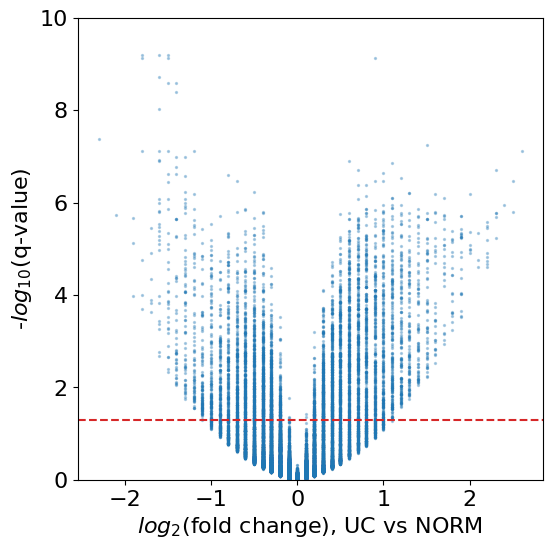

In [ ]:
#volcano plot for UC vs. normal

fig = plt.figure(figsize=(6, 6))
plt.scatter(query_results["UC_vs_NORM_fc"],
            -np.log10(query_results["UC_vs_NORM_p"]),
            alpha=0.3, s=2, label='Non-Pathway Genes')

# Highlight pathway genes with a different color from non-pathway genes
pathway_genes_mask = query_results["Gene Name"].isin(ibd_pathway)
plt.scatter(query_results.loc[pathway_genes_mask, "UC_vs_NORM_fc"],
            -np.log10(query_results.loc[pathway_genes_mask, "UC_vs_NORM_p"]),
            alpha=0.8, s=10, color='red', label='Pathway Genes')

ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xlabel(r'$\log_2$(Fold Change), UC vs NORM', fontsize=16)
ax.set_ylabel(r'-$\log_{10}$(q-value)', fontsize=16)
ax.set_ylim([0, 10])
ax.axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed', label='Significance Threshold')

# Create legend
ax.legend()

The volcano plot above shows us qualitatively if genes in our pathway of interest are upregulated or downregulated. Note that anything above the red dotted line is significant. Genes in our pathway are highlighted in red while all other genes are in blue. From the graph we can see that around 4 genes in our pathway of interest are upregulated in patients with ulcerative colitis compared to normal patients. We can also see that around 4 genes in our pathway of interest are downregulated in Crohn's patients with ulcerative colitis compared to normal patients. Let's quantitativly analyze the data to see whether our pathway of interest is significantly enriched in pateints with ulcerative colitis and determine whether our qualitative observations match our quantitative results. We will also examine whether the 4 genes downregulated in ulcerative colitis patients are the same 4 genes that are downregulated in Crohn's patients.

In [ ]:
# select genes upregulated in UC vs normal
fc_truth3 = analytics["'ulcerative colitis (disease)' vs 'normal'.log2foldchange"] > 0
# significance threshold of 0.05
q_val_truth3 = analytics["'ulcerative colitis (disease)' vs 'normal'.p-value"] < 0.05

# collect genes upregulated in UC vs normal
uc_slice = analytics[fc_truth3 & q_val_truth3]
uc_slice.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,'ulcerative colitis (disease)' vs 'normal'.p-value,'ulcerative colitis (disease)' vs 'normal'.log2foldchange
2,ENSG00000000419,DPM1,0.003457,0.4
5,ENSG00000000938,FGR,0.048836,0.5
25,ENSG00000002726,AOC1,0.042997,1.1
29,ENSG00000002834,LASP1,0.001242,0.5
30,ENSG00000002919,SNX11,0.000202,0.6
...,...,...,...,...
58292,ENSG00000285534,NaN,0.017380,1.2
58653,ENSG00000285906,NaN,0.011584,0.9
58656,ENSG00000285909,NaN,0.027332,1.1
58683,ENSG00000285938,NaN,0.002374,1.2


3345 of the 58735 genes in the dataset are significantly upregulated in UC.

In [ ]:
# determine which genes in both uc_slice & ibd_pathway
uc_cond = uc_slice['Gene Name'].isin(ibd_pathway)
uc_filter = uc_slice[uc_cond]
uc_filter.iloc[:, [0,1,10,11]]

,Gene ID,Gene Name,'ulcerative colitis (disease)' vs 'normal'.p-value,'ulcerative colitis (disease)' vs 'normal'.log2foldchange
3115,ENSG00000105483,CARD8,0.026615,0.4
7306,ENSG00000136634,IL10,0.002596,1.4
10982,ENSG00000163362,INAVA,0.006761,1.4
36901,ENSG00000243646,IL10RB,0.005262,0.6


Four genes--CARD8, IL10, INAVA, and IL10RB--are in both the IBD pathway and are significantly upregulated in UC.

In [ ]:
# number of genes in uc_cond
k = np.sum(uc_cond)
# number of genes in uc_slice
N = len(uc_slice)
# number of genes in both analytics & ibd_pathway
n = np.sum(query_results['Gene Name'].isin(ibd_pathway))
# number of genes in query)resukts
M=len(query_results)

print('k = ' + str(k))
print('N = ' + str(N))
print('n = ' + str(n))
print('M = ' + str(M))
print('Enrichment ratio: ' + str((k/N)/(n/M)))
print('p-value: ' + str(scipy.stats.hypergeom.sf(k=k-1,
                         N=N,
                         n=n,
                         M=M)))

k = 4
N = 3345
n = 13
M = 58735
Enrichment ratio: 5.402782568701852
p-value: 0.004954715873782243


The p-value of .005 (< .05) shows that the inflammatory bowel disease pathway is significantly enriched in those with ulcerative colitis. The enrichment ratio of 5.40 shows that the genes are about 5.40 times more prevalent among the input dataset than the reference dataset. This is expected, as UC is an IBD so we would expect these genes to be upregulated. However, it is somewhat unexpected that this pathway is upregulated in UC but downregulated in Crohn's disease. This could be due to the different mechanisms of each disease, or the fact that different genes were significantly upregulated and downregulated for each disease, producing different results.

# **GSEA Network Analysis**

We performed GSEA (GSEA with gene permutation) when comparing ulcerative colitis disease state to normal a normal bowel state . The cells below  import the expression data then created a file just showing the fold-change and gene name, which we used as an input to WebGestalt.

In [ ]:
# GSEA network analysis
de_df = query_results

As input, it takes tab-delimited file with genes in one column and fold-changes in the other (file extension .rnk).

In [ ]:
de_df_slice = de_df[["Gene Name", "UC_vs_NORM_fc"]].dropna()
de_df_slice.to_csv('ulc_vs_normal_fc_0.rnk', index=False, header=False, sep='\t')

These pathways are the three most up-regulated and three most down-regulated (highest and lowest NES) in the bowels during ulcerative colitis. Our genes were ranked by fold-change (dropping any genes with missing fold change value) and used Pathways > KEGG as our functional database in our WebGestalt input. These pathways suggest potential involvement of these biological processes in the context of ulcerative colitis in the bowels.
The three most upregulated KEGG pathways in the lung during ulcerative colitis disease are: Legionellosis, Complement and coagulation cascades, and NOD-like receptor signaling pathway.
The three most downregulated KEGG pathways in the lung during ulcerative colitis are: Natural killer cell mediated cytotoxicity, Antigen processing and presentation, and Graft-versus-host disease. These downregulated pathways in the lung during ulcerative colitis could indicate a suppression or alteration of these immune-related processes, providing insights into the impact of the disease on lung tissues.


# **Conclusions**

The study examined blood transciptomes from individuals with related autoimmune diseases, including juvenile idiopathic arthritis (JIA) and inflammatory bowel disease (IBD), as well as a normal control group.

The preliminary herartical clustering shows limited disease specificity. Hierarchical clustering revealed two main groups based on the more presence or less presence of Crohn's disease. The gene patterns associated with Crohn's disease and identified gene clusters related to osteoclast differentiation, graft-versus-host disease, metabolic functions, and cellular processes. Osteoclast differentiation was linked to JIA subtypes but less so with Crohn's disease group, highlighting the role of osteoclasts in juvenile idiopathic arthritis disease pathology. Further subdivision of the gene clusters and tissue-specific RNA-Seq could yield more insights into autoimmune disease specifics.

Our results from the over-representation analysis show that genes in the inflammatory bowel disease pathway are significantly downregulated in Crohn's disease and significantly upregulated in ulcerative colitis. This aligns with our expectations that patients with these diseases would have a significant change in expression of these genes because they are inflammatory bowel diseases. However, the differential gene expression in each disease suggests that Crohn's disease and UC have significantly different mechanisms.

 Our GSEA network analysis of ulcerative colitis in the bowels highlighted the three most up-regulated and down-regulated pathways, shedding light on potential biological processes implicated in the disease. By ranking genes based on fold-change and employing the Pathways > KEGG functional database, our findings gives insights into the molecular landscape of ulcerative colitis in the bowel tissues. Similarly, in the context of lung responses during ulcerative colitis, the identification of the most upregulated and downregulated KEGG pathways reveals potential alterations in immune-related processes, giving additional insights into the impact of the disease on lung tissues.

# **Work Acknowledgement**

**Emma** wrote the introduction and worked on the over-representation analysis. **Julia** worked on the normalization and the over-representation analysis. **Meng** worked on the normalization and the hierarchical clustering. **Luke** worked on the GSEA network analysis.